In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from collections import defaultdict
import json
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../data/2018/2018_mod.csv')

In [6]:
se = pd.read_csv('../../data/2018/18_start_end_dt.csv')
se = [(datetime.strptime(row.Start, '%Y-%m-%d %H:%M:%S.%f'), datetime.strptime(row.End, '%Y-%m-%d %H:%M:%S.%f')) for index,row in se.iterrows()]

def checkGreen(time):
    t = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f')
    for interval in se:
        if t > interval[0] and t < interval[1] + timedelta(minutes=2):
            return False
            
    return True

In [7]:
drivers = df['Driver'].unique()
lap_var = defaultdict(list)
drivers[0]

'Dane Cameron'

In [8]:
df['SDT'] = pd.to_datetime(df['Session Time'], format='%Y-%m-%d %H:%M:%S.%f')
LapDT = pd.to_datetime(df['Lap Time'], format='%M:%S.%f')
df['LTS'] = [(t - datetime(1900, 1, 1)).total_seconds() for t in LapDT]
df

,Car,Class,Driver,Lap,Lap Time,Session Time,Flag,Location,S01,S02,S03,SDT,LTS
0,60,DPi,Dane Cameron,1,1:33.516,1900-01-01 00:01:33.516000,Green,Track,22.848,34.595,35.924,1900-01-01 00:01:33.516,93.516
1,10,DPi,Ricky Taylor,1,1:35.417,1900-01-01 00:01:35.417000,Green,Track,22.959,36.004,36.453,1900-01-01 00:01:35.417,95.417
2,48,DPi,Kamui Kobayashi,1,1:36.550,1900-01-01 00:01:36.550000,Green,Track,22.767,36.688,36.714,1900-01-01 00:01:36.550,96.550
3,1,DPi,Renger van der Zande,1,1:36.976,1900-01-01 00:01:36.976000,Green,Track,23.153,36.878,36.699,1900-01-01 00:01:36.976,96.976
4,5,DPi,Tristan Vautier,1,1:37.730,1900-01-01 00:01:37.730000,Green,Track,23.084,37.111,36.947,1900-01-01 00:01:37.730,97.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6346,4,GTLM,Nick Tandy,187,1:45.783,1900-01-01 06:00:56.107000,Finish,Track,24.055,39.775,41.953,1900-01-01 06:00:56.107,105.783
6347,88,GTD,Katherine Legge,179,1:49.722,1900-01-01 06:00:58.292000,Finish,Track,25.343,41.624,42.755,1900-01-01 06:00:58.292,109.722
6348,12,GTD,Zach Veach,179,1:50.055,1900-01-01 06:01:03.180000,Finish,Track,25.346,41.587,43.122,1900-01-01 06:01:03.180,110.055
6349,36,LMP3,Oliver Askew,185,1:47.078,1900-01-01 06:01:03.807000,Finish,Track,24.336,39.460,43.282,1900-01-01 06:01:03.807,107.078


In [9]:
start_var_time = datetime(1900, 1, 1, 0, 10)
start_var_time

datetime.datetime(1900, 1, 1, 0, 10)

In [10]:
d = {}

In [11]:
for i in range(340):
    st = start_var_time + timedelta(minutes = i)
    et = start_var_time + timedelta(minutes = 10+i)
    
    temp = df[(df['SDT'] >= st) & (df['SDT'] <= et)]
    temp = temp[['Driver', 'LTS']].dropna()
    
    std_vals = temp.groupby('Driver').std()['LTS']
    std_vals = std_vals.dropna()
    d[i+10] = np.average(std_vals)

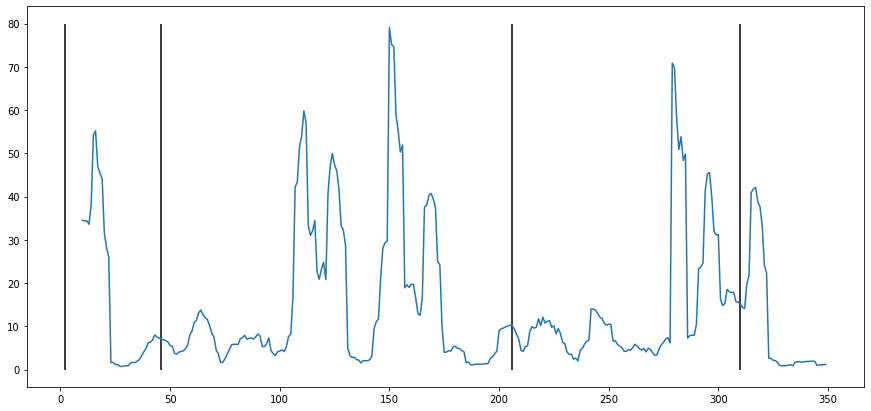

In [12]:
plt.figure(figsize=(15,7))
plt.plot(list(d.keys()), list(d.values()))
flagtimes = [120.0, 2760.0, 12400.0, 18620.0]
flagtimes_m = [f // 60 for f in flagtimes]
plt.vlines(flagtimes_m, 0, 80)

In [7]:
for driver in drivers:
    temp = df[df['Driver'] == driver]
    
    for i in range(temp.shape[0]-2): 
        r1 = temp.iloc[i]
        r2 = temp.iloc[i+1]
        r3 = temp.iloc[i+2]
        
        if checkGreen(r1['Session Time']) and checkGreen(r2['Session Time']) and checkGreen(r3['Session Time']):
            t1 = datetime.strptime(r1['Lap Time'], '%M:%S.%f')
            t1s = (t1 - datetime(1900, 1, 1)).total_seconds()
            t2 = datetime.strptime(r2['Lap Time'], '%M:%S.%f')
            t2s = (t2 - datetime(1900, 1, 1)).total_seconds()
            t3 = datetime.strptime(r3['Lap Time'], '%M:%S.%f')
            t3s = (t3 - datetime(1900, 1, 1)).total_seconds()
            
            times = [t1s, t2s, t3s]
            moving_var = np.array(times).var()
            
            lap_var[driver].append(moving_var)
        else:
            lap_var[driver].append(-1)

In [7]:
lap_var_f = {driver: variances for driver, variances in lap_var.items() if len(variances) > 2}

In [8]:
with open('../../data/2021/21_lap_var.csv', 'w') as f:
    f.write('Driver,Var\n')
    for d, v in lap_var_f.items():
        f.write("%s,%s\n"%(d,v))